In [1]:
## Importing desired libraries
import emcee
import numpy as np
import matplotlib.pyplot as plt
import Icarus
import astropy.units as u
import healpy as hp
import pyshtools as psh
from multiprocessing import Pool

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, Math
from matplotlib import rcParams
from scipy.optimize import minimize
import corner

import os
import time

Eclipse.py: The Eclipse module needs updating as it is not compatible with Python 3.x.
Eclipse.py: weave cannot be imported from scipy nor on its own.
Eclipse.py: The Shapely package cannot be imported. This module can but no eclipse optimization can be used.


In [2]:
## setting figure parameters
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

In [3]:
## the dictionary for the model

ip = {'q'        : 7.8, # Mass ratio, M2/M1 (m2 = nstar)/(m1 = companion)
      'porb'     : 4.75*60*60, # Porb, in seconds
      'incl'     : 0.8098328, # Inclination, in radians
      'k1'       : 282000, # Projected radial velocity of the companion in m/s
      'omega'    : 1.0, # Co-rotation factor, always=1.0
      'filling'  : 0.86, # Ratio of the secondary's radius along the line joining both stars to the distance to the L1 point.
      'tempgrav' : 0.25, #Exponent of the temperature dependance for gravity darkening. For a radiative core, = 0.25, for a fully convective star = 0.08.
      'temp'     : {'tbase': 5580, # The temperature of the cells of the companion prior to gravity darkening or to irradiation
                    'tirr' : 4903, # T**4 = Tbase**4+Tirr**4 (F=Fbase+Firr)
                   },
      'dm'       : 10.5, #distance modulus
      'av'       : 0.2263} # Extinction in magnitudes of the object at Johnson V band.        

In [52]:
phot = Icarus.Photometry.Photometry(atmo_fln="all_atmo.txt", data_fln="all_data.txt", ndiv=16)

In [5]:
## creating the first model
model_1 = phot.Get_flux(ip, influx = True)

Text(0, 0.5, 'Magnitude')

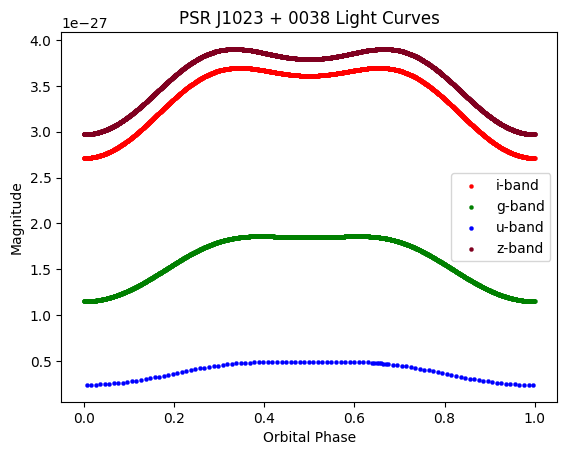

In [6]:
## Plotting the imported light curves
plt.scatter(phot.data['phase'][0], model_1[0], label='i-band', marker = '.', color = 'r', linewidths = 0.2)
plt.scatter(phot.data['phase'][1], model_1[1], label='g-band', marker = '.', color = 'g', linewidths = 0.2)
plt.scatter(phot.data['phase'][2], model_1[2], label='u-band', marker = '.', color = 'b', linewidths = 0.2)
plt.scatter(phot.data['phase'][3], model_1[3], label='z-band', marker = '.', color = '#800020', linewidths = 0.2)

ax = plt.gca()
##ax.invert_yaxis()

plt.legend()

plt.title('PSR J1023 + 0038 Light Curves')

plt.xlabel('Orbital Phase')
plt.ylabel('Magnitude')

Text(0, 0.5, 'Flux')

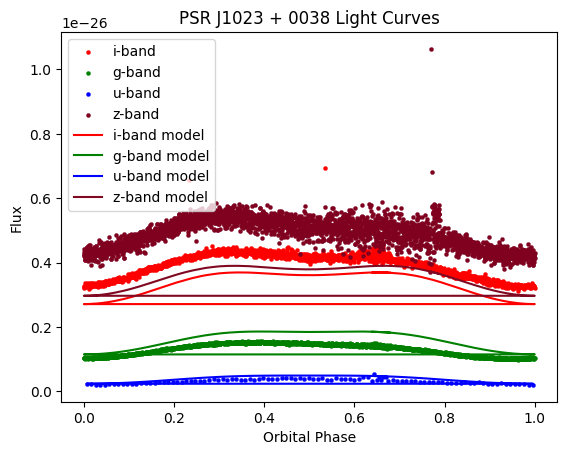

In [7]:
## Plotting the model lightcurves and data lightcurves

plt.scatter(phot.data['phase'][0], phot.data['flux'][0], label='i-band', marker = '.', color = 'r', linewidths = 0.2)
plt.scatter(phot.data['phase'][1], phot.data['flux'][1], label='g-band', marker = '.', color = 'g', linewidths = 0.2)
plt.scatter(phot.data['phase'][2], phot.data['flux'][2], label='u-band', marker = '.', color = 'b', linewidths = 0.2)
plt.scatter(phot.data['phase'][3], phot.data['flux'][3], label='z-band', marker = '.', color = '#800020', linewidths = 0.2)
plt.plot(phot.data['phase'][0], model_1[0], label='i-band model', color = 'r')
plt.plot(phot.data['phase'][1], model_1[1], label='g-band model', color = 'g')
plt.plot(phot.data['phase'][2], model_1[2], label='u-band model', color = 'b')
plt.plot(phot.data['phase'][3], model_1[3], label='z-band model', color = '#800820')


ax = plt.gca()
##ax.invert_yaxis()

plt.legend()

plt.title('PSR J1023 + 0038 Light Curves')

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')

In [8]:
print(phot.data['flux'][0])
print(phot.data['flux'][0][::-1])

[4.43767770e-27 4.46608671e-27 4.33138910e-27 ... 4.28356556e-27
 4.24386791e-27 4.02529181e-27]
[4.02529181e-27 4.24386791e-27 4.28356556e-27 ... 4.33138910e-27
 4.46608671e-27 4.43767770e-27]


Text(0, 0.5, 'Flux')

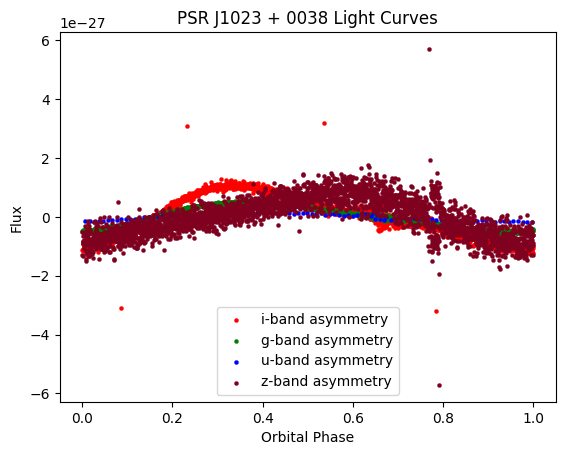

In [10]:
## demonstrating assymetries
plt.scatter(phot.data['phase'][0], phot.data['flux'][0] - phot.data['flux'][0][::-1], label='i-band asymmetry', marker = '.', color = 'r', linewidths = 0.2)
plt.scatter(phot.data['phase'][1], phot.data['flux'][1] - phot.data['flux'][1][::-1], label='g-band asymmetry', marker = '.', color = 'g', linewidths = 0.2)
plt.scatter(phot.data['phase'][2], phot.data['flux'][2] - phot.data['flux'][2][::-1], label='u-band asymmetry', marker = '.', color = 'b', linewidths = 0.2)
plt.scatter(phot.data['phase'][3], phot.data['flux'][3] - phot.data['flux'][3][::-1], label='z-band asymmetry', marker = '.', color = '#800020', linewidths = 0.2)



ax = plt.gca()
##ax.invert_yaxis()

plt.legend()

plt.title('PSR J1023 + 0038 Light Curves')

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')

In [11]:
## printing the chi^2 value
print(phot.Calc_chi2(ip, do_offset=True, full_output=False, influx=True))

123975.72893191101


In [12]:
chi2 = phot.Calc_chi2(ip, do_offset=True, full_output=False, influx=True)

In [13]:
# Calculating the number of data points
datapoints = len(phot.data['flux'][0]) + len(phot.data['flux'][1]) + len(phot.data['flux'][2]) + len(phot.data['flux'][3])

In [14]:
print(datapoints)

6837


In [15]:
## Calculating the reduced chi2
redchi2 = chi2 / datapoints
print(redchi2)

18.133059665337285


And now we're gonna try bringing in the mcmc stuffs:

In [242]:
## setting constants and true values for the mcmc
porb = 0.1980962019*24*60*60 # orbital period
G = 6.674e-11 # gravitational constant
sigq = 0.07939186878204116 # error in q
sigk1 = 9.6 * 1000 # error in K1
msol = 1.98849e30 # solar mass
tbase_true = 5432 # base temp
tirr_true = 4903 # irradiated temp
incl_true = 0.8098328 # inclination
dm_true = 10.501852725587815 # distance modulus
f_true = 0.86 # filling factor
av_true = 0.23 # extincion
q_true = 7.806847695110107 # mass ration
k_true = 282200 # companion radial velocity, k1
mpsr_true = 1.76 * msol #pulsar mass
mcomp_true = mpsr_true / q_true # companion mass

In [17]:
def log_likelihood(theta):
    global phot
    
    tbase, tirr, incl, dm, f, av, q, k = theta
    
    ip = {'q'        : q, # Mass ratio, M2/M1 (m2 = nstar)/(m1 = companion)
          'porb'     : 0.1980962019*24*60*60, # Porb, in seconds
          'incl'     : incl, # Inclination, in radians
          'k1'       : k, # Projected radial velocity of the companion in m/s
          'omega'    : 1.0, # Co-rotation factor, always=1.0
          'filling'  : f, # Ratio of the secondary's radius along the line joining both stars to the distance to the L1 point.
          'tempgrav' : 0.25, #Exponent of the temperature dependance for gravity darkening. For a radiative core, = 0.25, for a fully convective star = 0.08.
          'temp'     : {'tbase': tbase, # The temperature of the cells of the companion prior to gravity darkening or to irradiation
                        'tirr' : tirr, # T**4 = Tbase**4+Tirr**4 (F=Fbase+Firr)
                       },
          'dm'       : dm, #10.501852725587815
          'av'       : av} # Extinction in magnitudes of the object at Johnson V band.
    chi2 = phot.Calc_chi2(ip, do_offset=False, full_output=False, influx=True, nsamples = 50)
    

    return -0.5 * chi2

In [18]:
def log_prior(theta):
    tbase, tirr, incl, dm, f, av, q, k= theta
    if 3500 < tbase < 15000 and 3500 < tirr < 15000 and 0.01 < np.sin(incl) < 1 and 10 < dm < 10.5 and 0.001 < f < 0.999 and 0 < av < 1 and 7.568672088763983 < q < 8.04502330145623 and 272600 < k < 291800:
        pr_q = 1/(np.sqrt(2 * np.pi * (sigq**2))) * np.exp(-1/2*((q - q_true)/sigq)**2)
        np.log(pr_q)
        
        pr_k1 = 1/(np.sqrt(2 * np.pi * (sigk1**2))) * np.exp(-1/2*((k - k_true)/sigk1)**2)
        
        
        return np.log(np.sin(incl)) + np.log(pr_q) + np.log(pr_k1)
    return -np.inf

In [19]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [20]:
with Pool() as pool:
    pos = [5500,4900, 0.8,10.2, 0.9, 0.2, 7.8, 282200] + [1500,1500,1e-1,2e-1,2e-1,2e-1, 2e-1,15000] * np.random.randn(18, 8)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    state = sampler.run_mcmc(pos, 50000, progress=True)

  0%|                                                 | 0/50000 [00:00<?, ?it/s]/home/mark/Software/astropython/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████| 50000/50000 [5:29:21<00:00,  2.53it/s]


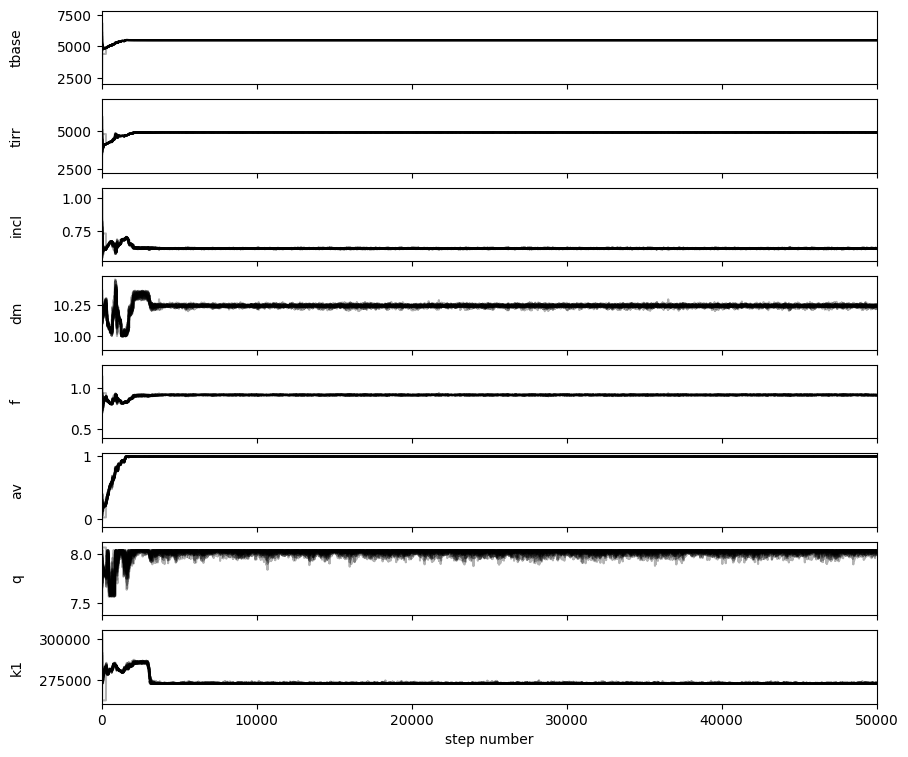

In [243]:
fig, axes = plt.subplots(8, figsize=(10, 9), sharex=True)
samples = sampler.get_chain()
labels = ["tbase", "tirr", "incl", "dm", "f", "av", "q", "k1", "mpsr", "mcomp"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [225]:
(samples)
## preparing to add the pulsar mass and companion mass to the results

array([[[ 4.29421794e+03,  5.10409662e+03,  6.58839432e-01, ...,
          1.23542535e-01,  7.64230693e+00,  2.80605503e+05],
        [ 5.87431724e+03,  2.45330996e+03,  6.88505785e-01, ...,
         -3.63287255e-02,  8.07803478e+00,  2.63612145e+05],
        [ 2.23221992e+03,  3.43811651e+03,  6.94531532e-01, ...,
          4.04190917e-01,  7.41239568e+00,  2.89966181e+05],
        ...,
        [ 4.38566879e+03,  5.24897347e+03,  9.16798317e-01, ...,
          5.18554969e-01,  7.81627363e+00,  2.76598195e+05],
        [ 6.84980759e+03,  5.93134726e+03,  7.83427925e-01, ...,
          2.79285752e-01,  7.92868391e+00,  3.03645751e+05],
        [ 4.96124497e+03,  4.82903585e+03,  6.65208408e-01, ...,
         -3.54795696e-02,  7.52551542e+00,  2.76727592e+05]],

       [[ 4.29421794e+03,  5.10409662e+03,  6.58839432e-01, ...,
          1.23542535e-01,  7.64230693e+00,  2.80605503e+05],
        [ 5.87431724e+03,  2.45330996e+03,  6.88505785e-01, ...,
         -3.63287255e-02,  8.07803478e

In [226]:
## creating a mass array
massarray = []

i = 0
j = 0

k = samples[:,:,7]
q = samples[:,:,6]
i = samples[:,:,2]
        
a = (porb * k**3)  
b = (1 +(1/q))**2
        
num = a*b

denom = 2 *np.pi * G * (np.sin(i))**3

mass = num/denom

mpsr = mass/msol
        
massarray.append(mpsr)

In [227]:
massarray
## transposing the mass array to be the correct shape
newmass = np.transpose(massarray, [1,2,0])

print(np.shape(massarray))
print(np.shape(newmass))
print(np.shape(samples))

(1, 50000, 18)
(50000, 18, 1)
(50000, 18, 8)


In [228]:
## concatonating the arrays
samples2 = np.concatenate((samples,newmass), axis = 2)
samples2[0][0]

array([4.29421794e+03, 5.10409662e+03, 6.58839432e-01, 1.03177039e+01,
       7.91254107e-01, 1.23542535e-01, 7.64230693e+00, 2.80605503e+05,
       2.52766931e+00])

In [251]:
try:
    tau = sampler.get_autocorr_time()
    print(tau)

except Exception:    
    print('error encountered here')

error encountered here


In [230]:
flat_samples = sampler.get_chain(discard=30000, thin=15, flat=True)
print(flat_samples.shape)

(23994, 8)


In [240]:
flat_samples2 = []
## repeating as above
k = flat_samples[:,7]
q = flat_samples[:,6]
i = flat_samples[:,2]
        
a = (porb * k**3)  
b = (1 +(1/q))**2
        
num = a*b

denom = 2 *np.pi * G * (np.sin(i))**3

mass = num/denom

mpsr = mass/msol

mass1 = []
        
mass1.append(mpsr)

mass2 = []

mcomp = mpsr/q

mass2.append(mcomp)

In [241]:
newmass = np.transpose(mass1, [1,0])
cmass = np.transpose(mass2, [1,0])

print(np.shape(mass1))
print(np.shape(newmass))
print(np.shape(flat_samples))

(1, 23994)
(23994, 1)
(23994, 8)


In [245]:
## adding the masses
flat_samples2 = np.concatenate((flat_samples,newmass), axis = 1)
flat_samples3 = np.concatenate((flat_samples2, cmass), axis = 1)

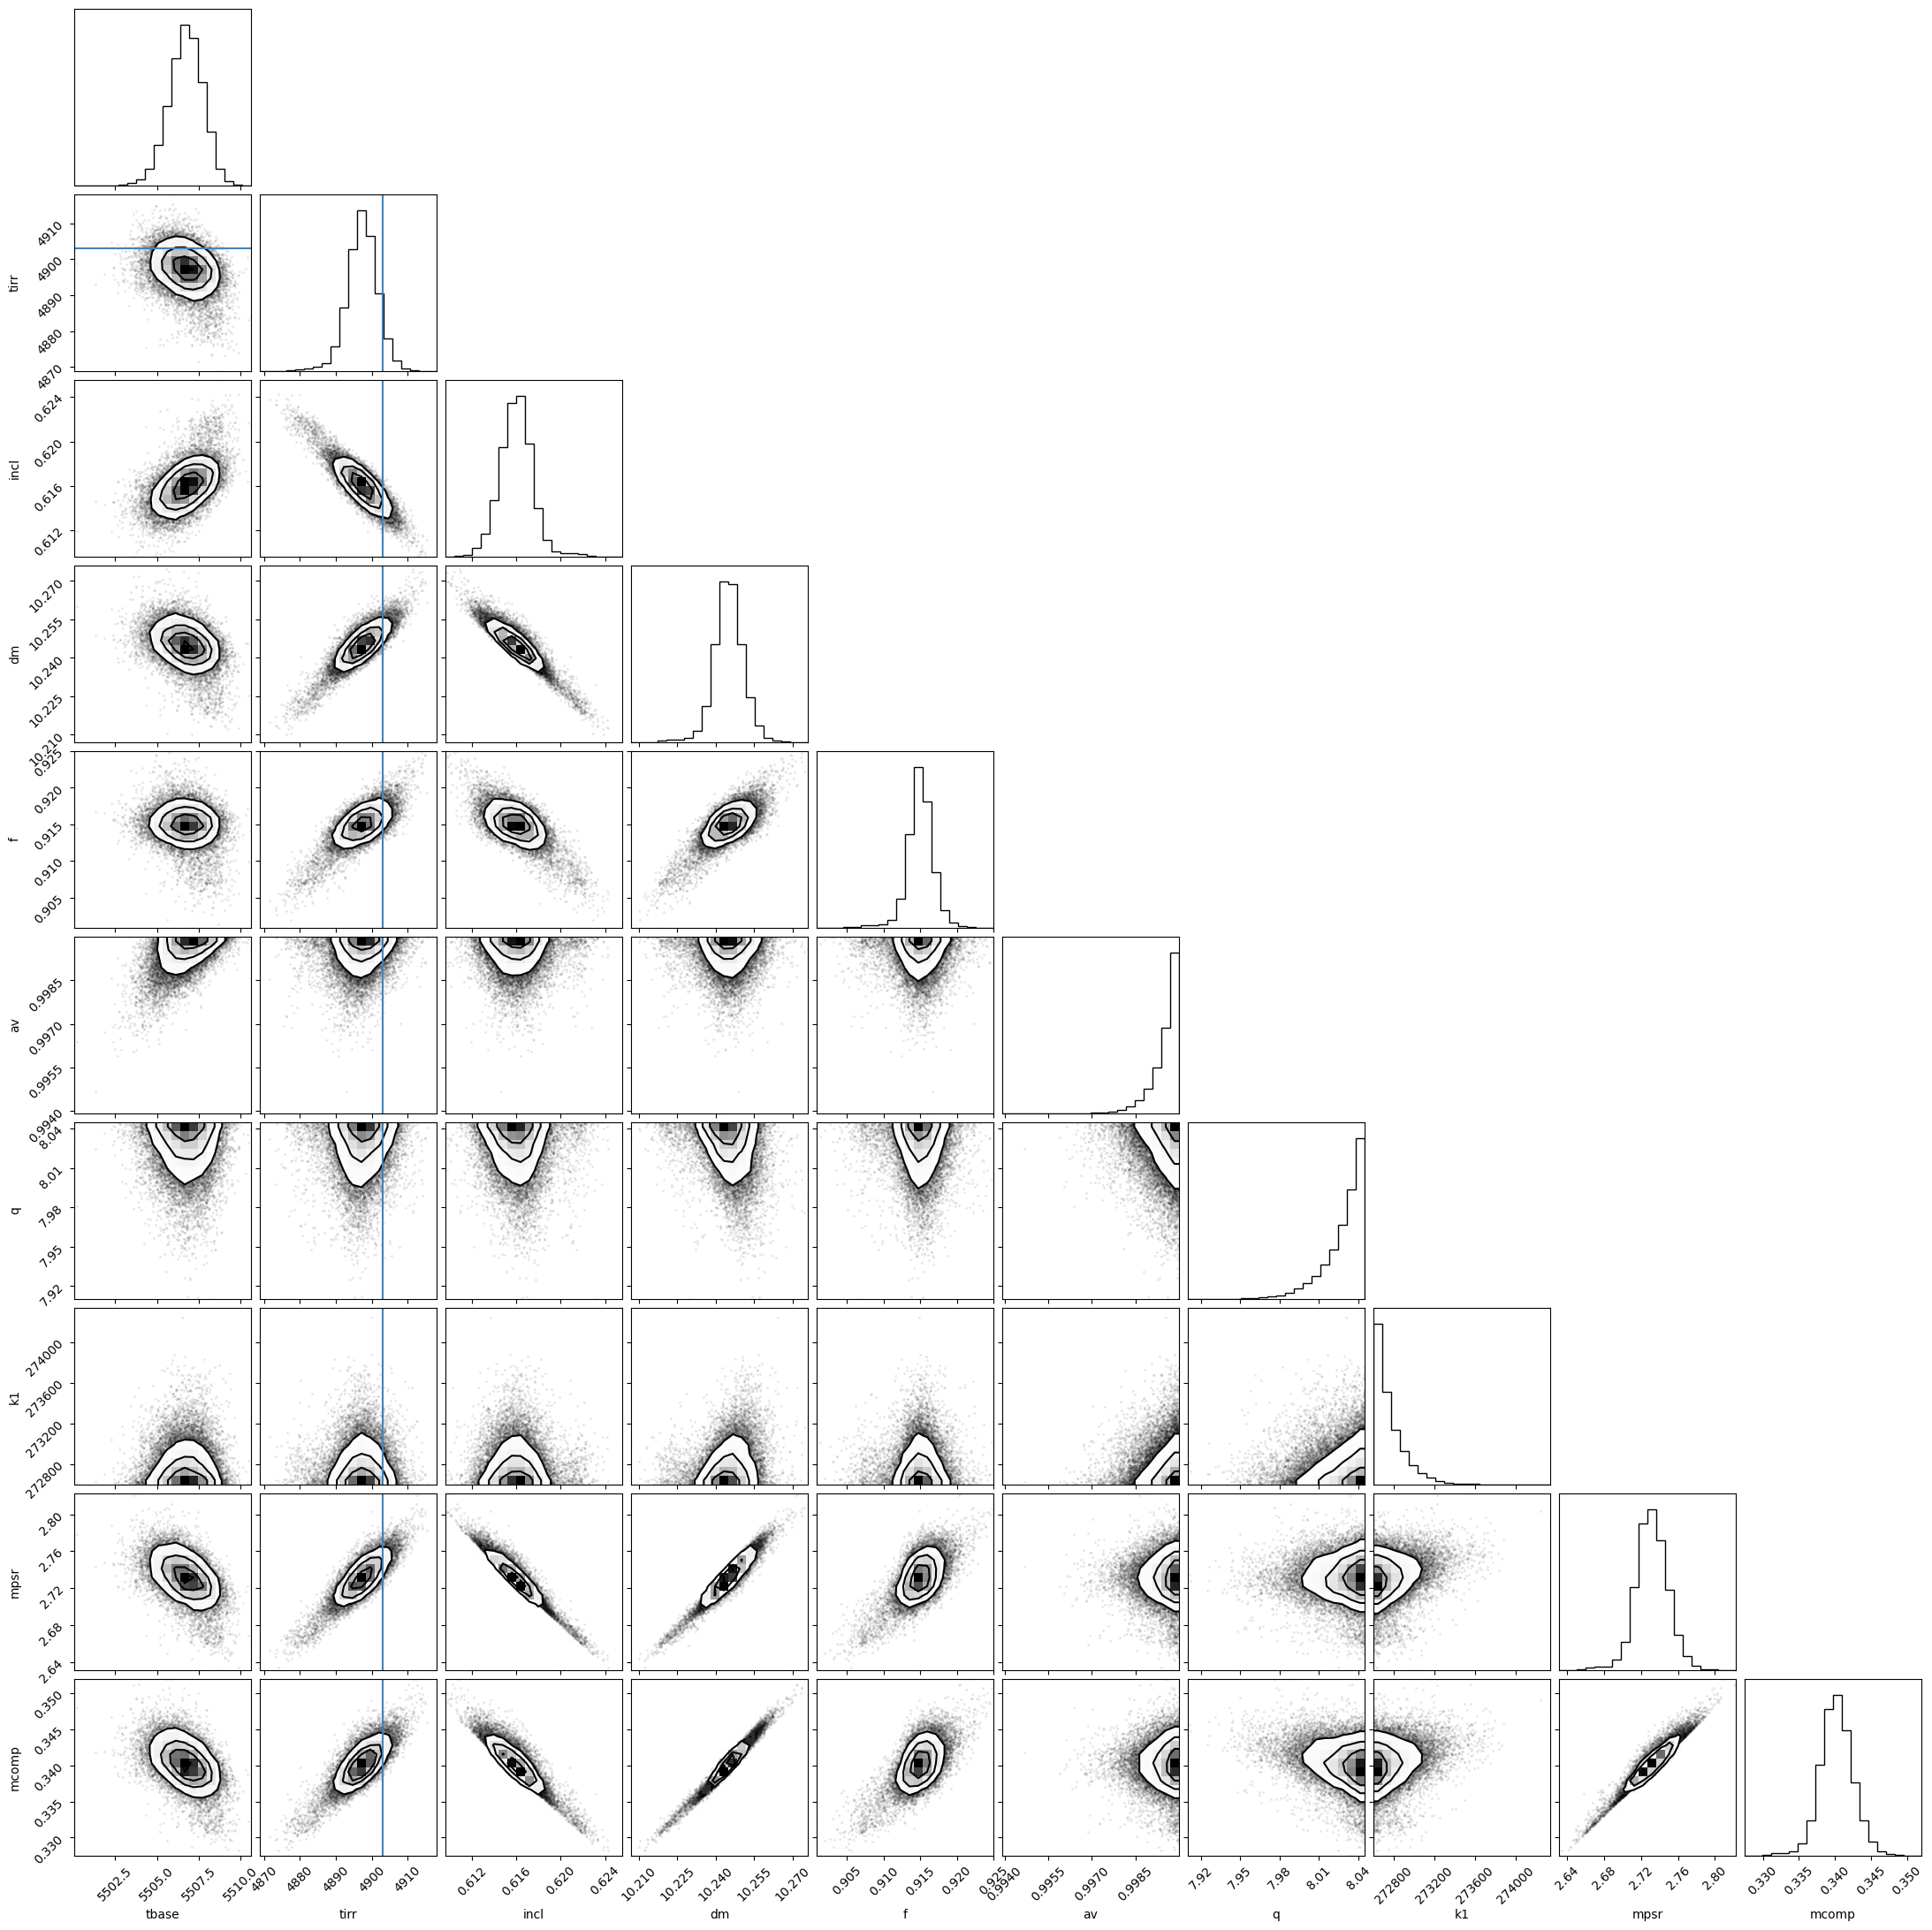

In [246]:
ig = corner.corner(
    flat_samples3, labels=labels, truths=[tbase_true, tirr_true, incl_true, dm_true, f_true, av_true, q_true, k_true, mpsr_true, mcomp_true]
);


In [253]:
answers = []

In [254]:
for i in range(ndim+2):
    mcmc = np.percentile(flat_samples3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    answers.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [255]:
answers

[5506.7649578455985,
 4897.429139403323,
 0.6159872287933489,
 10.244969604380941,
 0.9149937505683698,
 0.9996631680221191,
 8.033217959602947,
 272713.04992974823,
 2.7311648021592827,
 0.34018938661320325]

In [256]:
incldeg = answers[2] * 180 / np.pi
print(incldeg)

35.29346844381831


In [257]:
mpsr = ((porb * answers[7] **3)/(2*np.pi * G)) * (1 + (1/answers[6]))**2 / (np.sin(answers[2]))**3
mpsr = mpsr / msol
print(mpsr)

2.729425844123787


In [39]:
## creating an updated dictionary with the results
ipu = {'q'        : answers[6], # Mass ratio, M2/M1 (m2 = nstar)/(m1 = companion)
      'porb'     : 0.1980962019*24*60*60, # Porb, in seconds
      'incl'     : answers[2], # Inclination, in radians
      'k1'       : answers[7], # Projected radial velocity of the companion in m/s
      'omega'    : 1.0, # Co-rotation factor, always=1.0
      'filling'  : answers[4], # Ratio of the secondary's radius along the line joining both stars to the distance to the L1 point.
      'tempgrav' : 0.25, #Exponent of the temperature dependance for gravity darkening. For a radiative core, = 0.25, for a fully convective star = 0.08.
      'temp'     : {'tbase': answers[0], # The temperature of the cells of the companion prior to gravity darkening or to irradiation
                    'tirr' : answers[1], # T**4 = Tbase**4+Tirr**4 (F=Fbase+Firr)
                   },
      'dm'       : answers[3], #10.501852725587815, #this was via trial and error #20.501852725587817, # 5+5log10(D)  (distance modulus) dm = 5 + 5 * np.log10[1.26kpc]
      'av'       : answers[5]} # Extinction in magnitudes of the object at Johnson V band.
        

In [40]:
## creating an updated model
model_1u = phot.Get_flux(ipu, influx = True)

In [49]:
## calculating the chi2
print(phot.Calc_chi2(ipu, do_offset=True, full_output=True, influx=True))
datapoints = len(phot.data['flux'][0]) + len(phot.data['flux'][1]) + len(phot.data['flux'][2]) + len(phot.data['flux'][3])
chi2, results = phot.Calc_chi2(ipu, do_offset=True, full_output=True, influx=True)

(79392.4167395585, {'offset': array([ 0.0210632 , -0.01051007, -0.4933459 , -0.06377344]), 'par': {'q': 8.033217959602947, 'porb': 17115.51184416, 'incl': 0.6159872287933489, 'k1': 272713.04992974823, 'omega': 1.0, 'filling': 0.9149937505683698, 'tempgrav': 0.25, 'temp': {'tbase': 5506.7649578455985, 'tirr': 4897.429139403323}, 'dm': 10.244969604380941, 'av': 0.9996631680221191}, 'res': [array([ 1.46212093,  2.73416306,  1.2175975 , ...,  1.5205179 ,
        0.81945508, -3.30141329]), array([-1.68823676, -1.73299758, -2.68540371, ..., -1.91626725,
       -1.93825851, -0.37894956]), array([ 0.05621059,  0.28972129,  0.30198545, -0.78878686, -0.09185858,
       -0.57038557, -0.4679396 , -0.51932014, -0.14778233,  0.02364319,
       -0.95483978, -0.53761219, -0.86853551, -0.41208557, -0.28316385,
       -0.15526658, -0.62426851, -0.30777604, -0.35078356,  0.14855538,
        0.47395788,  0.48892679,  0.11277331,  0.67091424,  0.53158807,
        0.41048751,  0.45430272,  0.35840487,  0.69

Text(0, 0.5, 'Flux')

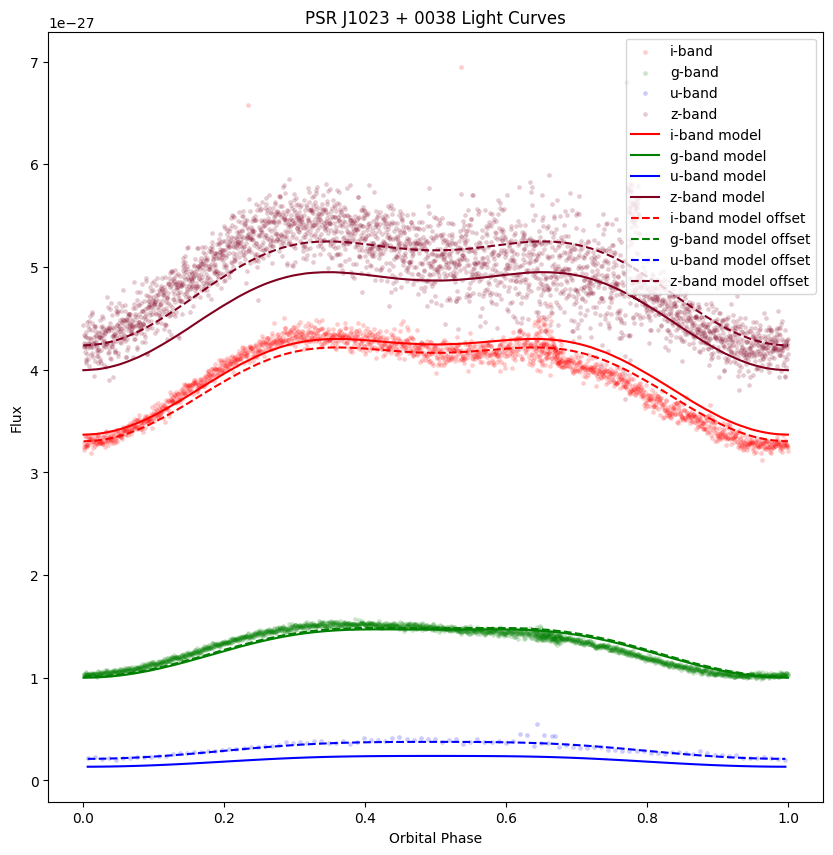

In [53]:
plt.rcParams['figure.figsize'] = [10, 10]
## plotting the data
plt.scatter(phot.data['phase'][0], phot.data['flux'][0], label='i-band', marker = '.', color = 'r', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][1], phot.data['flux'][1], label='g-band', marker = '.', color = 'g', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][2], phot.data['flux'][2], label='u-band', marker = '.', color = 'b', linewidths = 0.2, alpha = 0.2)
plt.scatter(phot.data['phase'][3], phot.data['flux'][3], label='z-band', marker = '.', color = '#800020', linewidths = 0.2, alpha = 0.2)
## plotting the model light curves
plt.plot(phot.data['phase'][0][np.argsort(phot.data['phase'][0])], model_1u[0][np.argsort(phot.data['phase'][0])], label='i-band model', color = 'r')
plt.plot(phot.data['phase'][1][np.argsort(phot.data['phase'][1])], model_1u[1][np.argsort(phot.data['phase'][1])], label='g-band model', color = 'g')
plt.plot(phot.data['phase'][2][np.argsort(phot.data['phase'][2])], model_1u[2][np.argsort(phot.data['phase'][2])], label='u-band model', color = 'b')
plt.plot(phot.data['phase'][3][np.argsort(phot.data['phase'][3])], model_1u[3][np.argsort(phot.data['phase'][3])], label='z-band model', color = '#800020')
## plotting the offset lightcurves
plt.plot(phot.data['phase'][0][np.argsort(phot.data['phase'][0])], model_1u[0][np.argsort(phot.data['phase'][0])]*10**(results['offset'][0]/-2.5), label='i-band model offset', color = 'r', linestyle = 'dashed')
plt.plot(phot.data['phase'][1][np.argsort(phot.data['phase'][1])], model_1u[1][np.argsort(phot.data['phase'][1])]*10**(results['offset'][1]/-2.5), label='g-band model offset', color = 'g', linestyle = 'dashed')
plt.plot(phot.data['phase'][2][np.argsort(phot.data['phase'][2])], model_1u[2][np.argsort(phot.data['phase'][2])]*10**(results['offset'][2]/-2.5), label='u-band model offset', color = 'b', linestyle = 'dashed')
plt.plot(phot.data['phase'][3][np.argsort(phot.data['phase'][3])], model_1u[3][np.argsort(phot.data['phase'][3])]*10**(results['offset'][3]/-2.5), label='z-band model offset', color = '#800020', linestyle = 'dashed')



ax = plt.gca()
##ax.invert_yaxis()

plt.legend()

plt.title('PSR J1023 + 0038 Light Curves')

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

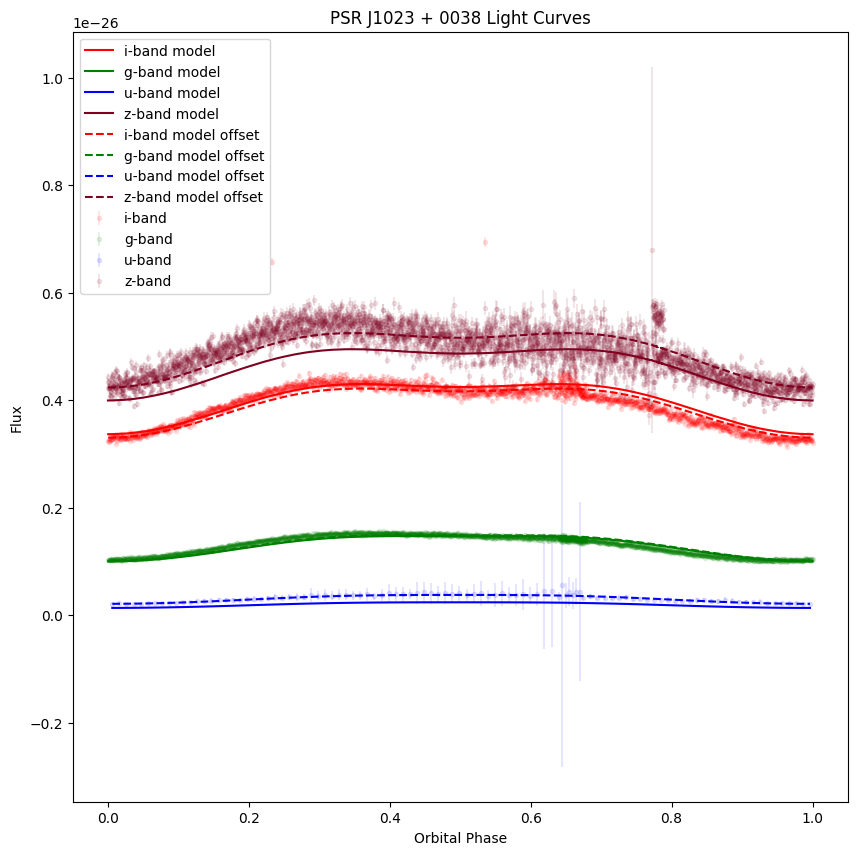

In [61]:
plt.rcParams['figure.figsize'] = [10, 10]
## as above but with error bars included
## data lightcurces
plt.errorbar(phot.data['phase'][0], phot.data['flux'][0], label='i-band',yerr=phot.data['flux_err'][0],fmt='.', color = 'r', alpha = 0.1)
plt.errorbar(phot.data['phase'][1], phot.data['flux'][1], label='g-band',yerr=phot.data['flux_err'][1],fmt='.', color = 'g', alpha = 0.1)
plt.errorbar(phot.data['phase'][2], phot.data['flux'][2], label='u-band',yerr=phot.data['flux_err'][2],fmt='.', color='b', alpha = 0.1)
plt.errorbar(phot.data['phase'][3], phot.data['flux'][3], label='z-band',yerr=phot.data['flux_err'][3],fmt='.', color='#800020', alpha = 0.1)
## model lightcurves
plt.plot(phot.data['phase'][0][np.argsort(phot.data['phase'][0])], model_1u[0][np.argsort(phot.data['phase'][0])], label='i-band model', color = 'r')
plt.plot(phot.data['phase'][1][np.argsort(phot.data['phase'][1])], model_1u[1][np.argsort(phot.data['phase'][1])], label='g-band model', color = 'g')
plt.plot(phot.data['phase'][2][np.argsort(phot.data['phase'][2])], model_1u[2][np.argsort(phot.data['phase'][2])], label='u-band model', color = 'b')
plt.plot(phot.data['phase'][3][np.argsort(phot.data['phase'][3])], model_1u[3][np.argsort(phot.data['phase'][3])], label='z-band model', color = '#800020')
## offset lightcurves
plt.plot(phot.data['phase'][0][np.argsort(phot.data['phase'][0])], model_1u[0][np.argsort(phot.data['phase'][0])]*10**(results['offset'][0]/-2.5), label='i-band model offset', color = 'r', linestyle = 'dashed')
plt.plot(phot.data['phase'][1][np.argsort(phot.data['phase'][1])], model_1u[1][np.argsort(phot.data['phase'][1])]*10**(results['offset'][1]/-2.5), label='g-band model offset', color = 'g', linestyle = 'dashed')
plt.plot(phot.data['phase'][2][np.argsort(phot.data['phase'][2])], model_1u[2][np.argsort(phot.data['phase'][2])]*10**(results['offset'][2]/-2.5), label='u-band model offset', color = 'b', linestyle = 'dashed')
plt.plot(phot.data['phase'][3][np.argsort(phot.data['phase'][3])], model_1u[3][np.argsort(phot.data['phase'][3])]*10**(results['offset'][3]/-2.5), label='z-band model offset', color = '#800020', linestyle = 'dashed')


ax = plt.gca()
##ax.invert_yaxis()

plt.legend()

plt.title('PSR J1023 + 0038 Light Curves')

plt.xlabel('Orbital Phase')
plt.ylabel('Flux')

In [51]:
print(phot.Calc_chi2(ipu, do_offset=True, full_output=False, influx=True))

79392.4167395585


In [43]:
chi2u = phot.Calc_chi2(ipu, do_offset=True, full_output=False, influx=True)

In [44]:
if chi2u < 16000:
    os.system('spd-say "desired value found"')

In [45]:
redchi2u = chi2u / datapoints
print(redchi2u)

11.612171528383573


In [258]:
#############